# Embedded ML Lab - Excercise 0 - Intro Training

Now that we have covered Neural Network Inference, we come to the training of neural networks. We reuse the LeNet from the previous exercise.

<span style="color:green">Your Task:</span>
* <span style="color:green">Copy your implementation of the LeNet from the last excercise into Cell1</span>

In Cell 2 the dataset is already prepared as a dataloader (using batch_size 32). Additionally, the images are already zero-centered and normalized. We have two separate data_loaders: `test_loader` for testing the accuracy of the model, and `train_data` for training the model. These two should not be mixed for their tasks. You can iterate over the batches of a dataloader by using `for idx, (input, targets) in enumerate(dataloader):`

Before we start with training, we need to write two functions. The first is `correct_predictions(outputs, targets)`, where you can reuse code from exercise_00. This function takes the outputs and targets as input and returns an int with the number of correct predictions in the batch. 
The second function `test_net(net, device)`. This function iterates over the testloader, applies the network's forward pass, and returns the overall accuracy of the model (all correct predictions of the testset overall testset predictions)

<span style="color:green">Your Tasks:</span>
* <span style="color:green">Implement the `correct_predictions` function (Cell 3)</span>
* <span style="color:green">Implement the `test_net` function (Cell 4)</span>
    * <span style="color:green">First set the network in evaluation mode with `.eval()` </span>
    * <span style="color:green">Iterate over the batches in the dataloader</span>
    * <span style="color:green">For each batch calculate the correct detected images</span>
    * NOTE: you can also only iterate over a fraction of batches to save some time
    * <span style="color:green">Return the overall Accuracy</span>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#---to-be-done-by-student---
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        #---to-be-done-by-student---
        self.conv1 = nn.Conv2d(1, 6, 3)  # out: 26x26x6 (maxpool)-> 13x13x6
        self.conv2 = nn.Conv2d(6, 16, 3) # out: 11x11x16(maxpool) -> 5x5x16
        self.fc1 = nn.Linear(400 , 120)  # in:  400x1 (prev: flatten)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.relu = F.relu
        self.maxpool = F.max_pool2d
        
        #---end---------------------
        return
    
    def forward(self,x):
        #---to-be-done-by-student---
        x = self.conv1(x)
        x = self.maxpool(self.relu(x), 2)

        x = self.conv2(x)
        x = self.maxpool(self.relu(x), 2)

        x = x.flatten(start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)        
        #---end---------------------
        return x
#---end---------------------
net = LeNet()

In [2]:
import torchvision
import time

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('.', train=False, download=True, transform=torchvision.transforms.Compose([
                                                torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(
                                                (0.1307, ), (0.3081)) ])), batch_size=64, shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('.', train=True, download=True, transform=torchvision.transforms.Compose([
                                                torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(
                                                (0.1307, ), (0.3081)) ])), batch_size=64, shuffle=False, drop_last=True)

In [3]:
def correct_predictions(outputs, targets):
    correct_predictions = 0
    #---to-be-done-by-student---
    for idx, output in enumerate(outputs):
        if torch.argmax(output) == targets[idx]:
            correct_predictions += 1
    #---end---------------------
    return correct_predictions

In [4]:
def test_net(net, device):
    #---to-be-done-by-student---
    correct_detected = 0
    overall = len(test_loader)*64
    net.eval()

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        #---to-be-done-by-student---
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = net(inputs)
        outputs_arg = outputs.argmax(dim=1)
        
        #print("Outputs:\t{}".format(outputs.shape))
        #print("Outputs_ARG:\t{}".format(outputs_arg.shape))
        #print("Targets:\t{}".format(targets.shape))

        for idx in range(len(targets)):
            if outputs_arg[idx] == targets[idx]:
                correct_detected += 1
        #---end---------------------  
        
    #---end---------------------
    return float(correct_detected/overall)

Now that we have these two helper functions we come to training the network. Some parts are already given. You can do the training either on the cpu or on the gpu (gpu should be faster).

First we define an optimizer `optimizer = torch.optim.SGD(net.parameters(), lr=0.01)` and hand in the model's parameters (e.g., weights and biases of the conv and linear layers). Besides the model's parameters, we set the learning rate to 0.01. The learning defines the step size for updating the parameters based on their gradients.

Also, we require a loss function `loss_function = nn.CrossEntropyLoss()`, which defines the error (loss) between the output of the network and the desired output target.
To train the network we iterate over the dataset several times (for 5 epochs).

We can split the training into five parts (for each training batch):   
<span style="color:green">Your Tasks:</span>   
* <span style="color:green">**Clean old gradients**: Remove the previous gradients of the parameters by calling `optimizer.zero_grad()`.</span>   
* <span style="color:green">**Forward Pass**: Similar to the previous inference experiments, 
    calculate the network's output.</span>   
* <span style="color:green">**Loss**: Calculate the loss by using `loss_function(outputs, targets)`.</span>   
* <span style="color:green">**Backpropagation of the error**: Call `.backward()` on the loss tensor and Pytorch will automatically calculate the respective gradients of the modules with respect to the input and parameters.</span>
* <span style="color:green">**Step**: As the last step, modify the parameters based on their gradients by calling `optimizer.step()`.</span>

Plotting the accuracy and loss of the model:

<span style="color:green">Your Tasks:</span> 
* <span style="color:green">Collect the network's loss for each batch.
* <span style="color:green">After every 100 batches calculate the networks average_loss (of last 100 batches).</span>
* <span style="color:green">Similar, calculate the models accuracy using using your defined `test_net` function.</span>
* <span style="color:green">Append the average loss and the accuracy to `loss_list` and `acc_list`, respectively.</span>

In [5]:
n_epochs = 5
loss_list = []
acc_list = []

net = LeNet()
device = torch.device('cuda')

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
loss_function = nn.CrossEntropyLoss()

#---to-be-done-by-student---
#you can define stuff here ...
softmax = nn.Softmax()
net.to(device)

#---end---------------------

for epoch_n in range(n_epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        #---to-be-done-by-student---
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        net.train()
        optimizer.zero_grad()
        outputs = net(inputs)
  
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        #---end---------------------
        if batch_idx % 100 == 0 and batch_idx != 0:
            
            #---to-be-done-by-student---
            loss = float(loss.to('cpu'))
            loss_list.append(loss)
            acc = test_net(net, device)
            # acc = acc.to('cpu')
            acc_list.append(acc)
            print("Loss: {},\tAccuracy: {}".format(loss, acc))
            #---end---------------------

Loss: 2.280308723449707,	Accuracy: 0.13321314102564102
Loss: 2.2391788959503174,	Accuracy: 0.4195713141025641
Loss: 1.8529764413833618,	Accuracy: 0.5122195512820513
Loss: 0.841978132724762,	Accuracy: 0.7511017628205128
Loss: 0.5418632626533508,	Accuracy: 0.8123998397435898
Loss: 0.4372287094593048,	Accuracy: 0.8625801282051282
Loss: 0.440756231546402,	Accuracy: 0.8671875
Loss: 0.423439621925354,	Accuracy: 0.8730969551282052
Loss: 0.44758981466293335,	Accuracy: 0.8934294871794872
Loss: 0.2843998670578003,	Accuracy: 0.8868189102564102
Loss: 0.20673711597919464,	Accuracy: 0.9119591346153846
Loss: 0.4044209122657776,	Accuracy: 0.8759014423076923
Loss: 0.1968509405851364,	Accuracy: 0.9204727564102564
Loss: 0.3437045216560364,	Accuracy: 0.9241786858974359
Loss: 0.16788619756698608,	Accuracy: 0.930488782051282
Loss: 0.27209141850471497,	Accuracy: 0.9349959935897436
Loss: 0.229604572057724,	Accuracy: 0.9375
Loss: 0.30610063672065735,	Accuracy: 0.9418068910256411
Loss: 0.1628722846508026,	Accur

Text(0.5, 1.0, 'LeNet training')

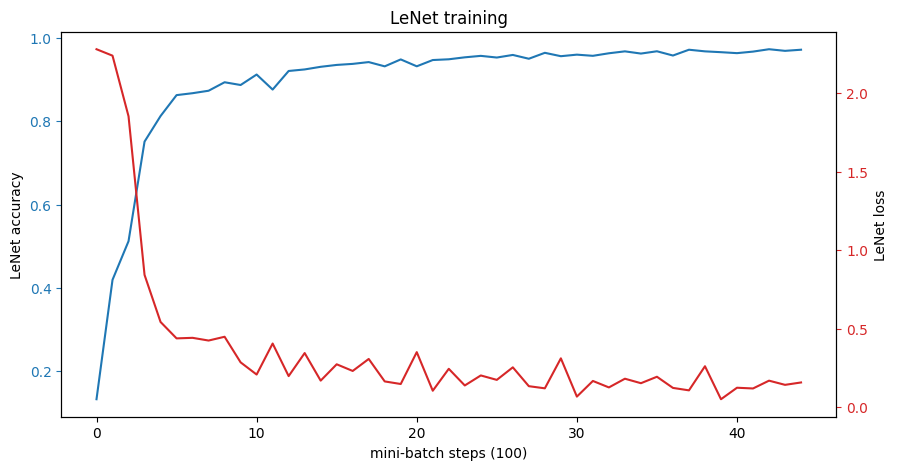

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]

fig, ax = plt.subplots(1)

ax.plot(np.array(acc_list), color='tab:blue')
ax.set_xlabel('mini-batch steps (100)')
ax.set_ylabel('LeNet accuracy')
ax.tick_params(colors='tab:blue', axis='y')

ax2 = ax.twinx()
ax2.plot(np.array(loss_list), color='tab:red')
ax2.set_ylabel('LeNet loss')
ax2.tick_params(colors='tab:red', axis='y')
ax.set_title('LeNet training')

You can save your training state by using `state_dict = net.state_dict()` and `torch.save(state_dict, 'lenet_new.pt')`

<span style="color:green">Your Task:</span>   
* <span style="color:green">Save the state dict of the model with a new name and plug it into exercise 01 by changing the file name in Cell 9</span>

In [7]:
#save model here
#---to-be-done-by-student---
for param in net.state_dict():
    print(param, "\t", net.state_dict()[param].size())

torch.save(net.state_dict(), "./LeNet_trained.pt")
#---end---------------------

conv1.weight 	 torch.Size([6, 1, 3, 3])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 3, 3])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
